In [55]:
## Expanded Credit Scoring Framework Using Machine Learning

In [23]:
# Install required libraries (run once)
!pip install lightgbm xgboost shap


In [39]:
# Import Dependencies & Set Global Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    f1_score, roc_curve, precision_recall_curve
)

import lightgbm as lgb
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

# Reproducibility
np.random.seed(42)


In [40]:
# 📁 Upload Dataset to Google Colab

from google.colab import files

uploaded = files.upload()

Saving Loan new datset.csv to Loan new datset (1).csv


In [27]:
!ls

'Loan new datset.csv'   sample_data


In [41]:
# Define the AlternativeCreditScorer class (end-to-end ML pipeline)

class AlternativeCreditScorer:
    """
    Alternative Credit Scoring Model

    This class implements a machine learning pipeline for predicting loan defaults
    using alternative data sources, excluding traditional credit information.
    """

    def __init__(self, model_type='lightgbm'):
        """
        Initialize the alternative credit scorer.

        Args:
            model_type (str): 'lightgbm' or 'xgboost'
        """
        self.model_type = model_type
        self.model = None
        self.feature_names = None
        self.preprocessor = None
        self.label_encoders = {}
        self.scaler = StandardScaler()

        # Define features to exclude (traditional credit data)
        self.excluded_features = [
            'CreditScore', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
            'LengthOfCreditHistory', 'PaymentHistory', 'PreviousLoanDefaults',
            'BankruptcyHistory', 'CreditCardUtilizationRate'
        ]

        # Define alternative features to use
        self.alternative_features = [
            'Age', 'AnnualIncome', 'EmploymentStatus', 'EducationLevel',
            'Experience', 'LoanAmount', 'LoanDuration', 'MaritalStatus',
            'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments',
            'LoanPurpose', 'SavingsAccountBalance', 'CheckingAccountBalance',
            'TotalAssets', 'TotalLiabilities', 'MonthlyIncome',
            'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth',
            'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment',
            'TotalDebtToIncomeRatio'
        ]

    def load_and_preprocess_data(self, file_path):
        """
        Load and preprocess the dataset.

        Args:
            file_path (str): Path to the CSV file

        Returns:
            tuple: (X, y) features and target
        """
        df = pd.read_csv(file_path)

        # Remove excluded features (traditional credit data)
        df_alt = df.drop(columns=self.excluded_features, errors='ignore')

        # Create target variable (1 = default, 0 = no default)
        # Assuming LoanApproved = 0 means default, LoanApproved = 1 means approved
        df_alt['default'] = (df_alt['LoanApproved'] == 0).astype(int)

        # Select alternative features
        available_features = [col for col in self.alternative_features if col in df_alt.columns]

        # Separate features and target
        X = df_alt[available_features]
        y = df_alt['default']

        # Remove rows with missing target
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]

        return X, y

    def encode_categorical_features(self, X):
        """
        Encode categorical features using frequency encoding for high-cardinality features
        and label encoding for low-cardinality features.

        Args:
            X (pd.DataFrame): Input features

        Returns:
            pd.DataFrame: Encoded features
        """
        X_encoded = X.copy()

        for col in X.columns:
            if X[col].dtype == 'object':
                # Frequency encoding for high-cardinality features
                if X[col].nunique() > 10:
                    freq_encoding = X[col].value_counts(normalize=True)
                    X_encoded[col] = X[col].map(freq_encoding)
                else:
                    # Label encoding for low-cardinality features
                    le = LabelEncoder()
                    X_encoded[col] = le.fit_transform(X[col].astype(str))
                    self.label_encoders[col] = le

        return X_encoded

    def handle_missing_values(self, X):
        """
        Handle missing values in the dataset.

        Args:
            X (pd.DataFrame): Input features

        Returns:
            pd.DataFrame: Features with missing values handled
        """
        X_clean = X.copy()

        # For numerical features, impute with median
        numerical_cols = X.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if X[col].isnull().sum() > 0:
                median_val = X[col].median()
                X_clean[col].fillna(median_val, inplace=True)

        # For categorical features, impute with mode
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if X[col].isnull().sum() > 0:
                mode_val = X[col].mode()[0]
                X_clean[col].fillna(mode_val, inplace=True)

        return X_clean

    def create_model(self):
        """
        Create the machine learning model.

        Returns:
            model: Trained model
        """
        if self.model_type == 'lightgbm':
            model = lgb.LGBMClassifier(
                n_estimators=1000,
                learning_rate=0.05,
                max_depth=6,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                early_stopping_rounds=50,
                verbose=-1
            )
        else:  # xgboost
            model = xgb.XGBClassifier(
                n_estimators=1000,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                early_stopping_rounds=50,
                eval_metric='logloss'
            )

        return model

    def train_model(self, X, y):
        """
        Train the alternative credit scoring model.

        Args:
            X (pd.DataFrame): Training features
            y (pd.Series): Target variable
        """
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Handle missing values
        X_train_clean = self.handle_missing_values(X_train)
        X_test_clean = self.handle_missing_values(X_test)

        # Encode categorical features
        X_train_encoded = self.encode_categorical_features(X_train_clean)
        X_test_encoded = self.encode_categorical_features(X_test_clean)

        # Scale numerical features
        numerical_cols = X_train_encoded.select_dtypes(include=[np.number]).columns
        X_train_scaled = X_train_encoded.copy()
        X_test_scaled = X_test_encoded.copy()

        X_train_scaled[numerical_cols] = self.scaler.fit_transform(X_train_encoded[numerical_cols])
        X_test_scaled[numerical_cols] = self.scaler.transform(X_test_encoded[numerical_cols])

        # Store feature names
        self.feature_names = X_train_scaled.columns.tolist()

        # Create and train model
        self.model = self.create_model()

        # Use cross-validation for early stopping
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        if self.model_type == 'lightgbm':
            self.model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_test_scaled, y_test)],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )
        else:  # xgboost
            self.model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_test_scaled, y_test)],
                verbose=False
            )

        # Make predictions
        y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        y_pred = self.model.predict(X_test_scaled)

        # Store test data for evaluation
        self.X_test = X_test_scaled
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_proba = y_pred_proba

        # Store training data for overfitting analysis
        self.X_train = X_train_scaled
        self.y_train = y_train

        return X_test_scaled, y_test, y_pred, y_pred_proba

    def evaluate_model(self):
        """
        Evaluate the model performance.
        """
        # Calculate metrics
        auc = roc_auc_score(self.y_test, self.y_pred_proba)
        f1 = f1_score(self.y_test, self.y_pred)

        # Confusion matrix
        cm = confusion_matrix(self.y_test, self.y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Default', 'Default'],
                   yticklabels=['No Default', 'Default'])

        # Add accuracy percentage in the corner
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum() * 100
        plt.text(0.02, 0.98, f'Accuracy: {accuracy:.1f}%',
                transform=plt.gca().transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()


        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

        return auc, f1

    def analyze_overfitting(self):
        """
        Analyze training vs testing performance to check for overfitting.
        """
        # Get predictions on training data
        y_train_pred_proba = self.model.predict_proba(self.X_train)[:, 1]
        y_train_pred = self.model.predict(self.X_train)

        # Calculate metrics for training data
        train_auc = roc_auc_score(self.y_train, y_train_pred_proba)
        train_f1 = f1_score(self.y_train, y_train_pred)
        train_accuracy = (y_train_pred == self.y_train).mean()

        # Calculate metrics for test data
        test_auc = roc_auc_score(self.y_test, self.y_pred_proba)
        test_f1 = f1_score(self.y_test, self.y_pred)
        test_accuracy = (self.y_pred == self.y_test).mean()

        # Create comparison table
        comparison_df = pd.DataFrame({
            'Metric': ['AUC', 'F1 Score', 'Accuracy'],
            'Training': [train_auc, train_f1, train_accuracy],
            'Testing': [test_auc, test_f1, test_accuracy],
            'Difference': [train_auc - test_auc, train_f1 - test_f1, train_accuracy - test_accuracy]
        })

        # Create comprehensive performance comparison visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Training vs Testing ROC curves
        fpr_train, tpr_train, _ = roc_curve(self.y_train, y_train_pred_proba)
        fpr_test, tpr_test, _ = roc_curve(self.y_test, self.y_pred_proba)

        ax1.plot(fpr_train, tpr_train, label=f'Training (AUC = {train_auc:.3f})', linewidth=2, color='blue')
        ax1.plot(fpr_test, tpr_test, label=f'Testing (AUC = {test_auc:.3f})', linewidth=2, color='red')
        ax1.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('Training vs Testing ROC Curves')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Performance metrics comparison bar chart
        metrics = ['AUC', 'F1 Score', 'Accuracy']
        training_scores = [train_auc, train_f1, train_accuracy]
        testing_scores = [test_auc, test_f1, test_accuracy]

        x = np.arange(len(metrics))
        width = 0.35

        bars1 = ax2.bar(x - width/2, training_scores, width, label='Training', color='blue', alpha=0.7)
        bars2 = ax2.bar(x + width/2, testing_scores, width, label='Testing', color='red', alpha=0.7)

        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

        ax2.set_xlabel('Metrics')
        ax2.set_ylabel('Score')
        ax2.set_title('Training vs Testing Performance Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(metrics)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 1.1)

        # 3. Performance differences
        differences = [train_auc - test_auc, train_f1 - test_f1, train_accuracy - test_accuracy]
        colors = ['green' if diff < 0.05 else 'orange' for diff in differences]

        bars3 = ax3.bar(metrics, differences, color=colors, alpha=0.7)

        # Add value labels on bars
        for bar, diff in zip(bars3, differences):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
                    f'{diff:.4f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Overfitting Threshold')
        ax3.axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
        ax3.set_xlabel('Metrics')
        ax3.set_ylabel('Difference (Training - Testing)')
        ax3.set_title('Performance Differences')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Overfitting status summary
        ax4.axis('off')

        # Determine overall overfitting status
        max_diff = max(abs(diff) for diff in differences)
        if max_diff > 0.05:
            status = "⚠️ POTENTIAL OVERFITTING"
            status_color = "red"
            recommendation = "Consider reducing model complexity or collecting more data"
        else:
            status = "✅ NO SIGNIFICANT OVERFITTING"
            status_color = "green"
            recommendation = "Model generalizes well to unseen data"

        # Create summary text
        summary_text = f"""
        OVERFITTING ANALYSIS SUMMARY

        {status}

        Performance Differences:
        • AUC: {differences[0]:.4f}
        • F1 Score: {differences[1]:.4f}
        • Accuracy: {differences[2]:.4f}

        Maximum Difference: {max_diff:.4f}
        Threshold: 0.0500

        Recommendation:
        {recommendation}
        """

        ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        plt.tight_layout()
        plt.savefig('comprehensive_overfitting_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        return comparison_df

    def analyze_feature_importance(self):
        """
        Analyze feature importance using SHAP values.
        """
        # Get feature importance from model
        if self.model_type == 'lightgbm':
            importance = self.model.feature_importances_
        else:  # xgboost
            importance = self.model.feature_importances_

        # Create feature importance DataFrame
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{self.model_type.upper()} Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

        return feature_importance_df

    def generate_loan_approval_rules(self):
        """
        Generate simple rules for loan approval based on model insights.
        """
        # Get feature importance
        if self.model_type == 'lightgbm':
            importance = self.model.feature_importances_
        else:
            importance = self.model.feature_importances_

        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        top_features = feature_importance_df.head(5)['feature'].tolist()

        return top_features

    def predict_loan_approval(self, applicant_data):
        """
        Predict loan approval for a new applicant.

        Args:
            applicant_data (dict): Dictionary containing applicant features

        Returns:
            dict: Prediction results
        """
        # Convert to DataFrame
        df_applicant = pd.DataFrame([applicant_data])

        # Handle missing values
        df_applicant_clean = self.handle_missing_values(df_applicant)

        # Encode categorical features
        df_applicant_encoded = self.encode_categorical_features(df_applicant_clean)

        # Scale numerical features
        numerical_cols = df_applicant_encoded.select_dtypes(include=[np.number]).columns
        df_applicant_scaled = df_applicant_encoded.copy()
        df_applicant_scaled[numerical_cols] = self.scaler.transform(df_applicant_encoded[numerical_cols])

        # Make prediction
        default_probability = self.model.predict_proba(df_applicant_scaled)[0, 1]
        approval_probability = 1 - default_probability

        # Determine recommendation
        if default_probability < 0.3:
            recommendation = "APPROVE"
            risk_level = "LOW"
        elif default_probability < 0.6:
            recommendation = "REVIEW"
            risk_level = "MEDIUM"
        else:
            recommendation = "DECLINE"
            risk_level = "HIGH"

        return {
            'default_probability': default_probability,
            'approval_probability': approval_probability,
            'recommendation': recommendation,
            'risk_level': risk_level
        }

    def predict_loan_approval_detailed(self, applicant_data):
        """
        Predict loan approval with detailed analysis and SHAP explanations.

        Args:
            applicant_data (dict): Dictionary containing applicant features

        Returns:
            dict: Detailed prediction results with explanations
        """
        # Convert to DataFrame
        df_applicant = pd.DataFrame([applicant_data])

        # Handle missing values
        df_applicant_clean = self.handle_missing_values(df_applicant)

        # Encode categorical features
        df_applicant_encoded = self.encode_categorical_features(df_applicant_clean)

        # Scale numerical features
        numerical_cols = df_applicant_encoded.select_dtypes(include=[np.number]).columns
        df_applicant_scaled = df_applicant_encoded.copy()
        df_applicant_scaled[numerical_cols] = self.scaler.transform(df_applicant_encoded[numerical_cols])

        # Make prediction
        default_probability = self.model.predict_proba(df_applicant_scaled)[0, 1]
        approval_probability = 1 - default_probability

        # Determine recommendation
        if default_probability < 0.3:
            recommendation = "APPROVE"
            risk_level = "LOW"
        elif default_probability < 0.6:
            recommendation = "REVIEW"
            risk_level = "MEDIUM"
        else:
            recommendation = "DECLINE"
            risk_level = "HIGH"

        # Get feature contributions based on model feature importance
        feature_contributions = []
        for i, feature in enumerate(self.feature_names):
            # Use feature importance as a proxy for contribution
            importance = self.model.feature_importances_[i] if hasattr(self.model, 'feature_importances_') else 0
            feature_contributions.append({
                'feature': feature,
                'value': df_applicant_scaled.iloc[0][feature],
                'contribution': importance,
                'abs_contribution': abs(importance)
            })

        # Sort by absolute contribution
        feature_contributions.sort(key=lambda x: x['abs_contribution'], reverse=True)
        top_contributions = feature_contributions[:10]

        # Create detailed output
        detailed_result = {
            'default_probability': default_probability,
            'approval_probability': approval_probability,
            'recommendation': recommendation,
            'risk_level': risk_level,
            'applicant_data': applicant_data,
            'top_contributing_features': top_contributions
        }

        return detailed_result

    def create_applicant_analysis_visualization(self, detailed_prediction):
        """
        Create a comprehensive visualization for applicant analysis.

        Args:
            detailed_prediction (dict): Detailed prediction results
        """
        # Create a 2x2 subplot layout
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Applicant Summary (top left)
        ax1.axis('off')
        summary_text = f"""
        APPLICANT ANALYSIS SUMMARY

        Default Risk: {detailed_prediction['default_probability']:.3f}
        Approval Probability: {detailed_prediction['approval_probability']:.3f}
        Recommendation: {detailed_prediction['recommendation']}
        Risk Level: {detailed_prediction['risk_level']}

        Key Applicant Data:
        • Age: {detailed_prediction['applicant_data']['Age']}
        • Annual Income: ${detailed_prediction['applicant_data']['AnnualIncome']:,}
        • Employment: {detailed_prediction['applicant_data']['EmploymentStatus']}
        • Education: {detailed_prediction['applicant_data']['EducationLevel']}
        • Loan Amount: ${detailed_prediction['applicant_data']['LoanAmount']:,}
        • Loan Duration: {detailed_prediction['applicant_data']['LoanDuration']} months
        """

        ax1.text(0.1, 0.9, summary_text, transform=ax1.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        # 2. Top Contributing Factors (top right)
        top_features = detailed_prediction['top_contributing_features'][:8]
        features = [f['feature'] for f in top_features]
        contributions = [f['contribution'] for f in top_features]
        colors = ['green' if c > 0 else 'red' for c in contributions]

        bars = ax2.barh(features, contributions, color=colors, alpha=0.7)
        ax2.set_xlabel('Feature Contribution')
        ax2.set_title('Top Contributing Factors')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, contrib in zip(bars, contributions):
            width = bar.get_width()
            ax2.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                    f'{contrib:.4f}', ha='left' if width >= 0 else 'right', va='center', fontsize=10)

        # 3. Risk Assessment (bottom left)
        risk_prob = detailed_prediction['default_probability']
        approval_prob = detailed_prediction['approval_probability']

        # Create pie chart for risk breakdown
        labels = ['Default Risk', 'Approval Probability']
        sizes = [risk_prob, approval_prob]
        colors_pie = ['red', 'green']

        wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                           startangle=90)
        ax3.set_title('Risk Assessment Breakdown')

        # 4. Recommendation Analysis (bottom right)
        ax4.axis('off')

        if detailed_prediction['default_probability'] < 0.3:
            status = "✅ APPROVE"
            status_color = "green"
            explanation = "Low default risk indicates strong creditworthiness"
        elif detailed_prediction['default_probability'] < 0.6:
            status = "⚠️ REVIEW"
            status_color = "orange"
            explanation = "Mixed indicators require manual review"
        else:
            status = "❌ DECLINE"
            status_color = "red"
            explanation = "High default risk suggests decline"

        recommendation_text = f"""
        RECOMMENDATION ANALYSIS

        {status}

        Risk Level: {detailed_prediction['risk_level']}

        Explanation:
        {explanation}

        Key Factors:
        • Loan Amount: ${detailed_prediction['applicant_data']['LoanAmount']:,}
        • Income: ${detailed_prediction['applicant_data']['AnnualIncome']:,}
        • Debt Ratio: {detailed_prediction['applicant_data']['TotalDebtToIncomeRatio']:.2f}
        • Assets: ${detailed_prediction['applicant_data']['TotalAssets']:,}
        """

        ax4.text(0.1, 0.9, recommendation_text, transform=ax4.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        plt.tight_layout()
        plt.savefig('applicant_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        return fig

In [42]:
# Initialize Credit Scorer & Load Dataset

# Initialize scorer
scorer = AlternativeCreditScorer(model_type='lightgbm')

# Load data
X, y = scorer.load_and_preprocess_data("Loan new datset.csv")

print("Shape of features:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))

Shape of features: (20000, 24)
Target distribution:
default
1    0.761
0    0.239
Name: proportion, dtype: float64


In [43]:
# 🏋️ Train the Alternative Credit Scoring Model

X_test, y_test, y_pred, y_pred_proba = scorer.train_model(X, y)

Training until validation scores don't improve for 50 rounds


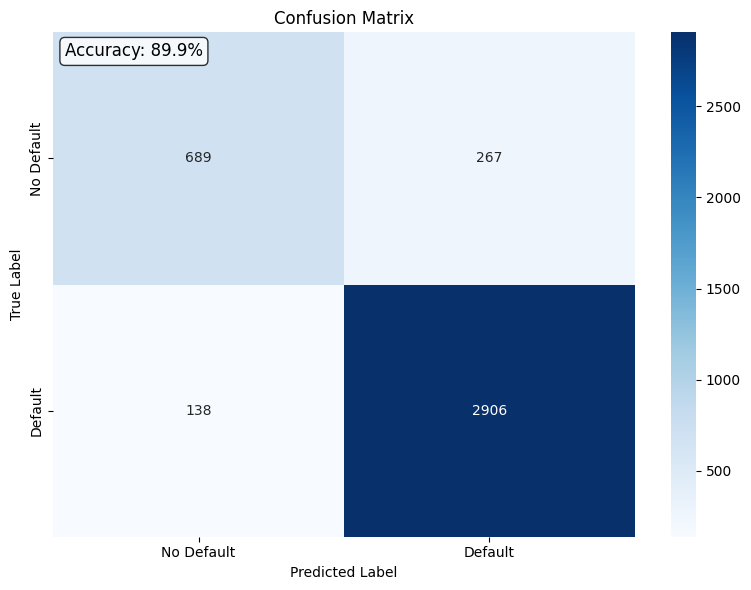

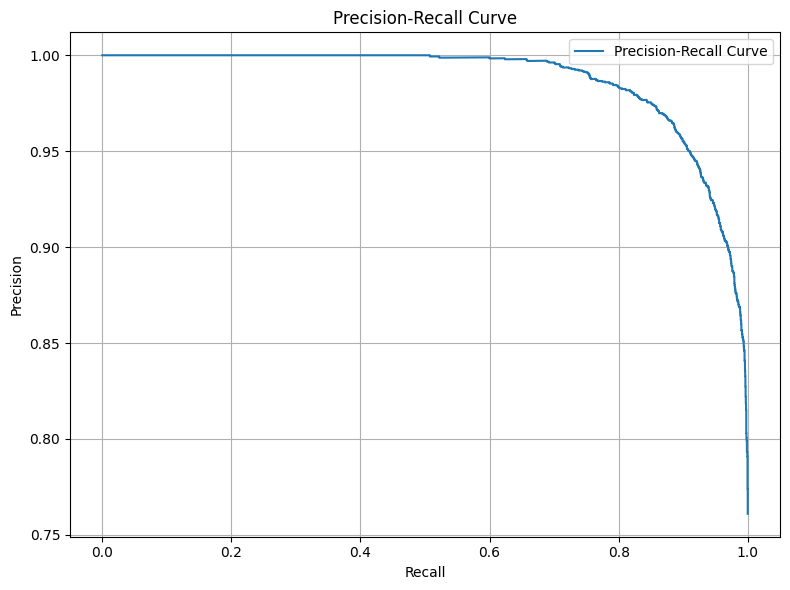

AUC Score: 0.9588
F1 Score: 0.9349


In [44]:
# 📊 Evaluate Model Performance

auc, f1 = scorer.evaluate_model()

print(f"AUC Score: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")

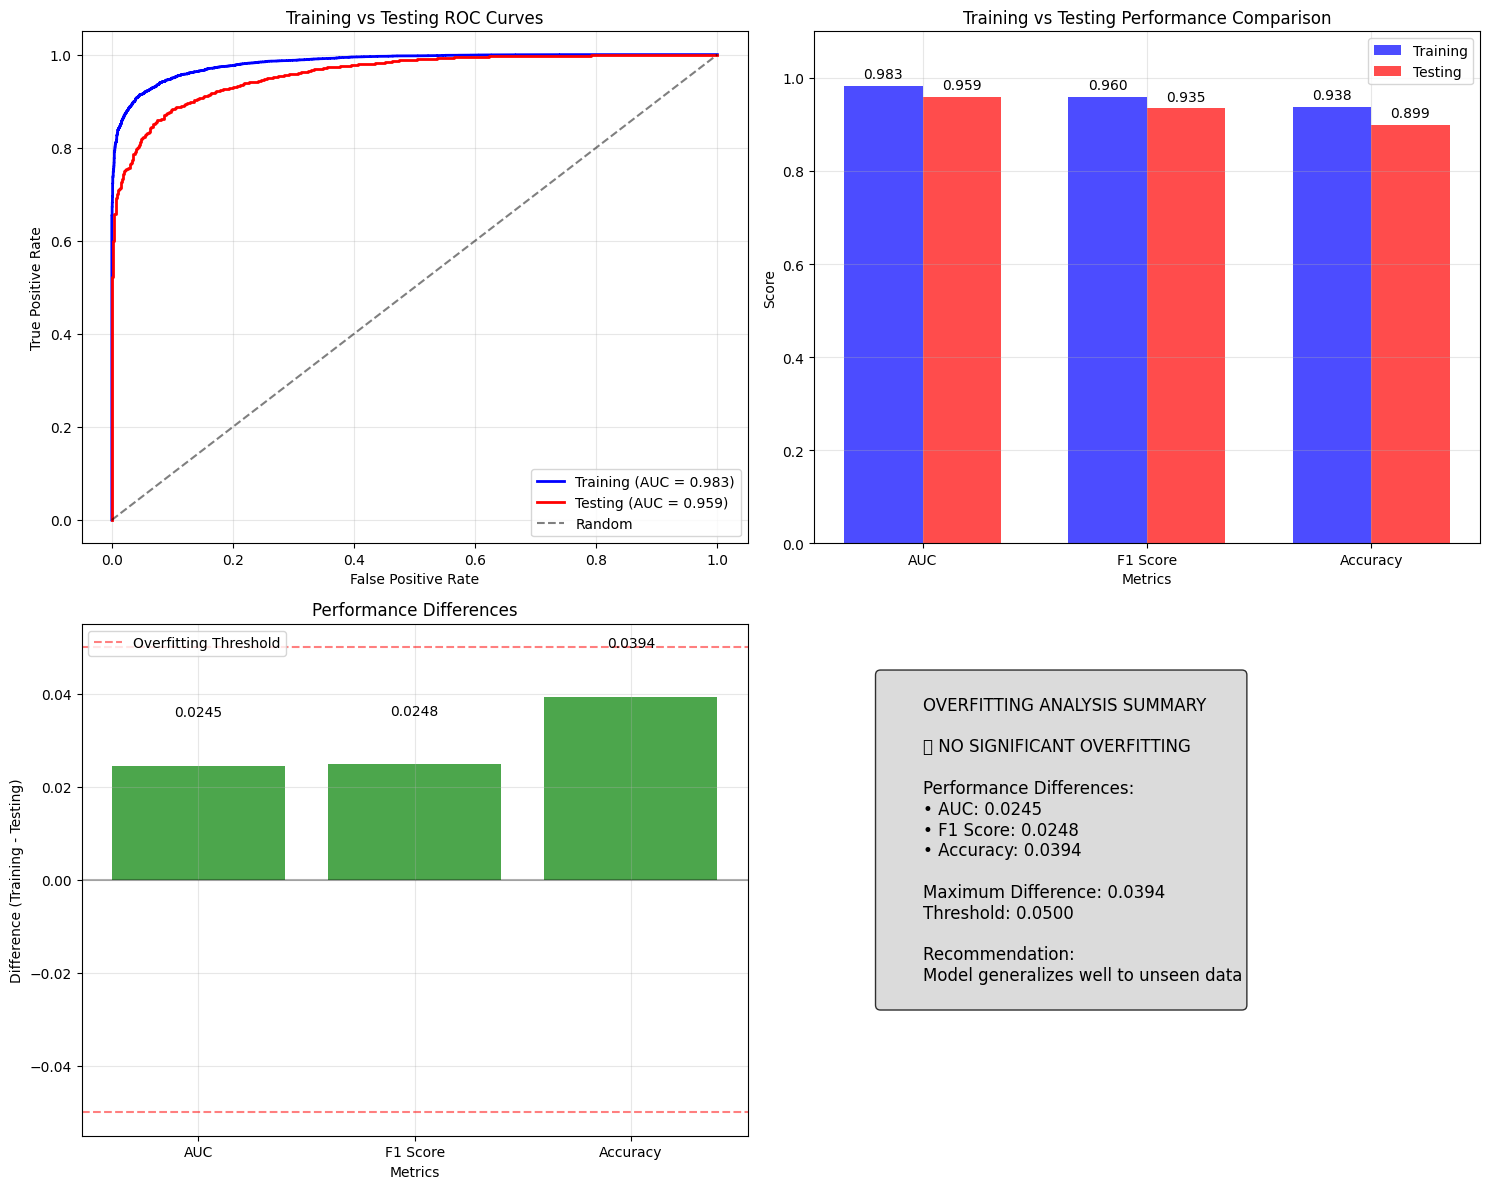

,Metric,Training,Testing,Difference
0,AUC,0.983293,0.958754,0.024539
1,F1 Score,0.959651,0.934856,0.024795
2,Accuracy,0.938125,0.898750,0.039375


In [45]:
# 🔍 Analyze Overfitting & Model Generalization

overfitting_df = scorer.analyze_overfitting()
overfitting_df

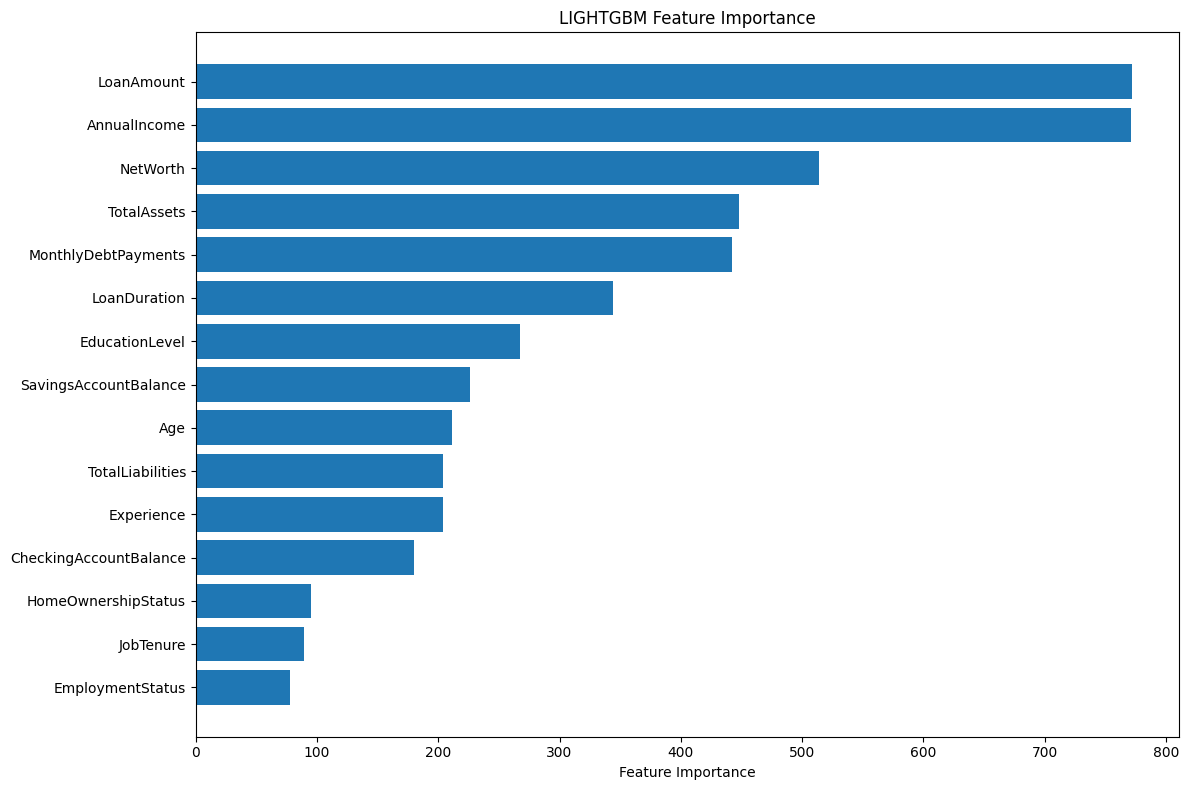

,feature,importance
5,LoanAmount,772
1,AnnualIncome,771
19,NetWorth,514
14,TotalAssets,448
10,MonthlyDebtPayments,442
6,LoanDuration,344
3,EducationLevel,267
12,SavingsAccountBalance,226
0,Age,211
15,TotalLiabilities,204


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='importance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

In [46]:
# 🌟 Analyze Feature Importance

feature_importance_df = scorer.analyze_feature_importance()
feature_importance_df.head(10)

In [47]:
# Top features influencing approval:

top_features = scorer.generate_loan_approval_rules()
print("Top features influencing approval:")
top_features

Top features influencing approval:


['LoanAmount',
 'AnnualIncome',
 'NetWorth',
 'TotalAssets',
 'MonthlyDebtPayments']

In [48]:
# 🧍 Define Sample Loan Applicant Data

sample_applicant = {
    'Age': 45,
    'AnnualIncome': 100000,
    'EmploymentStatus': 'Employed',
    'EducationLevel': 'Bachelor',
    'Experience': 18,
    'LoanAmount': 20000,
    'LoanDuration': 36,
    'MaritalStatus': 'Married',
    'NumberOfDependents': 1,
    'HomeOwnershipStatus': 'Mortgage',
    'MonthlyDebtPayments': 500,
    'LoanPurpose': 'Debt Consolidation',
    'SavingsAccountBalance': 5000,
    'CheckingAccountBalance': 2000,
    'TotalAssets': 100000,
    'TotalLiabilities': 50000,
    'MonthlyIncome': 8000,
    'UtilityBillsPaymentHistory': 5,
    'JobTenure': 5,
    'NetWorth': 50000,
    'BaseInterestRate': 5.0,
    'InterestRate': 7.0,
    'MonthlyLoanPayment': 600,
    'TotalDebtToIncomeRatio': 0.3
}

In [49]:
# 🧠 Generate Detailed Loan Approval Prediction

detailed_prediction = scorer.predict_loan_approval_detailed(sample_applicant)

detailed_prediction

{'default_probability': np.float64(0.3004431551818209),
 'approval_probability': np.float64(0.699556844818179),
 'recommendation': 'REVIEW',
 'risk_level': 'MEDIUM',
 'applicant_data': {'Age': 45,
  'AnnualIncome': 100000,
  'EmploymentStatus': 'Employed',
  'EducationLevel': 'Bachelor',
  'Experience': 18,
  'LoanAmount': 20000,
  'LoanDuration': 36,
  'MaritalStatus': 'Married',
  'NumberOfDependents': 1,
  'HomeOwnershipStatus': 'Mortgage',
  'MonthlyDebtPayments': 500,
  'LoanPurpose': 'Debt Consolidation',
  'SavingsAccountBalance': 5000,
  'CheckingAccountBalance': 2000,
  'TotalAssets': 100000,
  'TotalLiabilities': 50000,
  'MonthlyIncome': 8000,
  'UtilityBillsPaymentHistory': 5,
  'JobTenure': 5,
  'NetWorth': 50000,
  'BaseInterestRate': 5.0,
  'InterestRate': 7.0,
  'MonthlyLoanPayment': 600,
  'TotalDebtToIncomeRatio': 0.3},
 'top_contributing_features': [{'feature': 'LoanAmount',
   'value': np.float64(-0.36337943891826197),
   'contribution': np.int32(772),
   'abs_contr

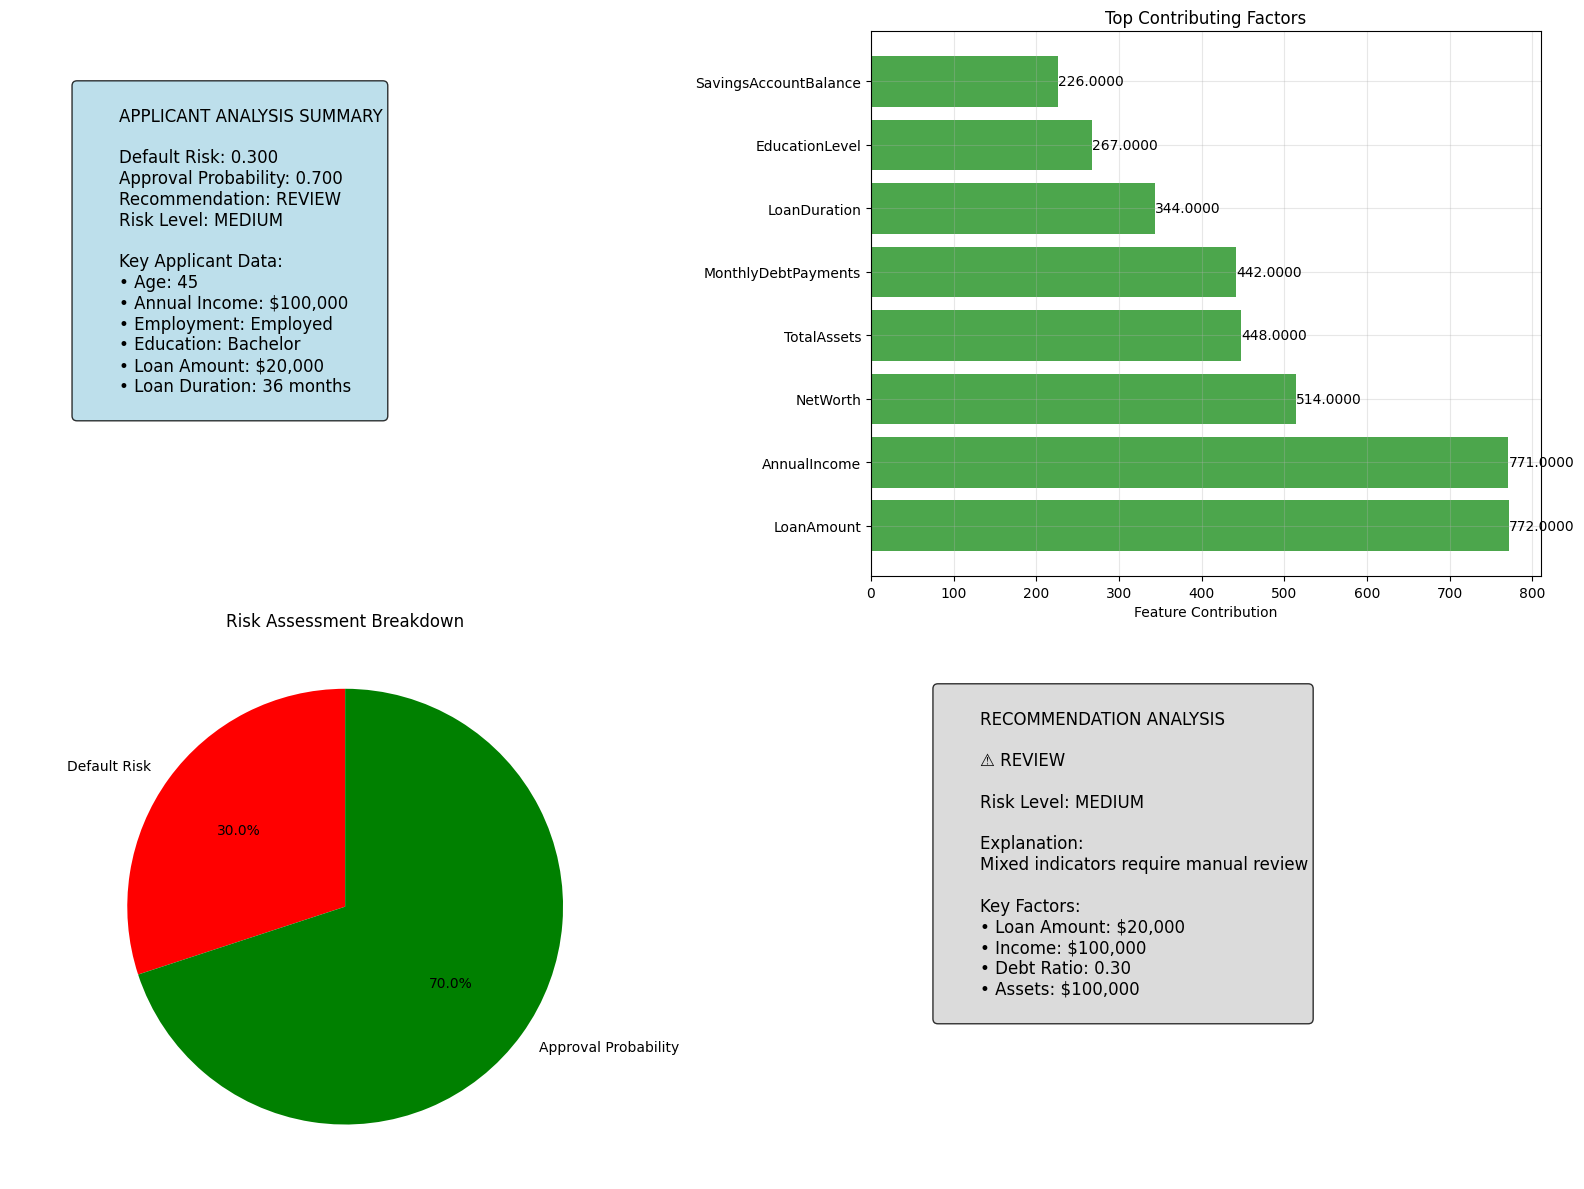

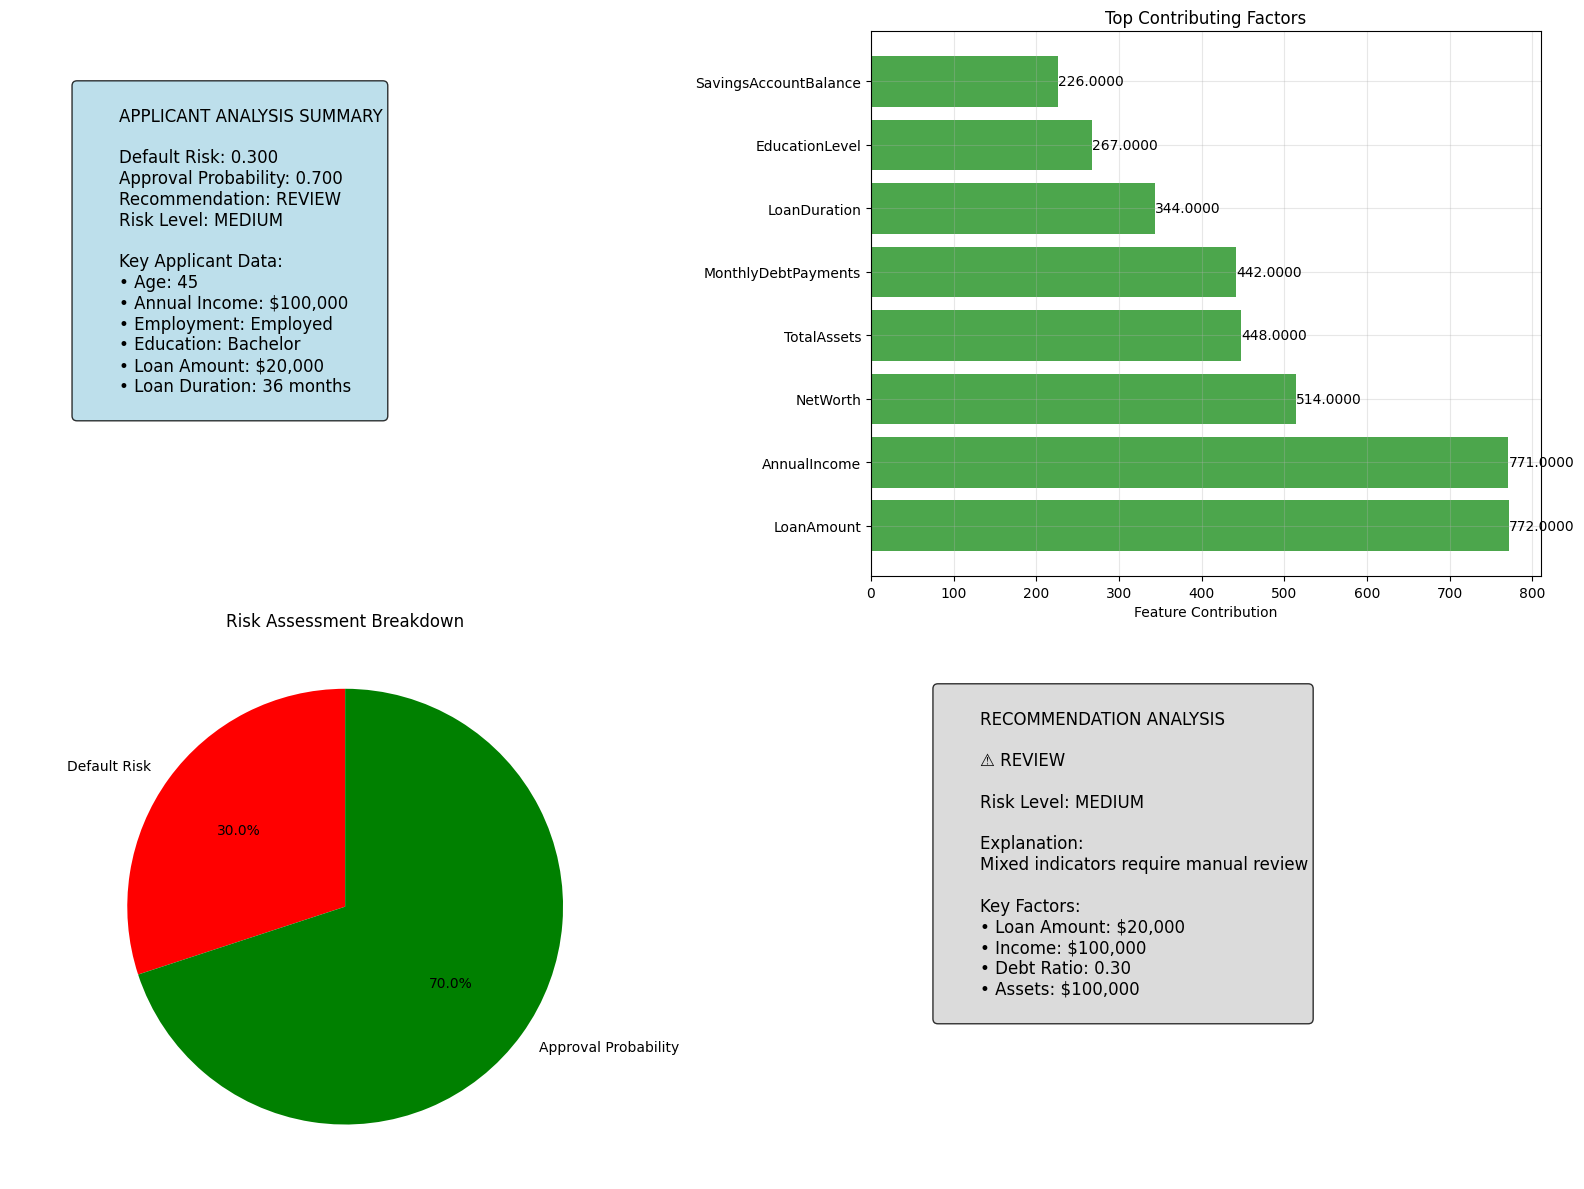

In [50]:
# 📈 Visualize Applicant Risk & Recommendation

scorer.create_applicant_analysis_visualization(detailed_prediction)

In [51]:
print("="*60)
print("ALTERNATIVE CREDIT SCORING PIPELINE COMPLETED")
print("="*60)
print(f"Model: {scorer.model_type.upper()}")
print(f"Final Performance - AUC: {auc:.4f}, F1: {f1:.4f}")

ALTERNATIVE CREDIT SCORING PIPELINE COMPLETED
Model: LIGHTGBM
Final Performance - AUC: 0.9588, F1: 0.9349
